In [1]:
#Importing the data
import pandas as pd
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, SVD, accuracy, PredictionImpossible
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from collections import defaultdict
#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
data.head()
# Create an empty DataFrame
metrics_df = pd.DataFrame(columns=['Index','Model','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [2]:
class Svd (SVD):
    def __init__(self, n_factors, n_epochs, biased, lr_all, reg_all, verbose):#, bsl_options={}):
       SVD.__init__(self, 
                    n_factors= n_factors, n_epochs = n_epochs,
                      biased= biased, lr_all= lr_all, 
                      reg_all= reg_all, verbose = verbose)#, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
    # # option 1
    # ########################################
    # # for cross validation we have two functions, cross_validate and fit
    # def cross_validate(self, measures=['RMSE'], cv=3, verbose=False):
    #     results = cross_validate(self, self.data, measures=measures, cv=cv, verbose=verbose)
    #     for measure in measures:
    #         print(f'{measure}: {results["test_" + measure.lower()].mean()}')
    #     return results
    
    # def fit(self, trainset):
    #     predictions = KNNWithMeans.fit(self, trainset).test(trainset.build_testset())
    #     self.sim = self.compute_similarities()
    #     self.bu, self.bi = self.compute_baselines()
    #     return predictions
    ########################################
    #option 2
    #######################################
    # fit funtion that works without cross validation
    def fit (self):
        self.trainset, testset = train_test_split(self.data, test_size=0.2)
        predictions = SVD.fit(self, self.trainset).test(testset)
        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    #######################################

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        # Compute similarities between u and v, where v describes all other
        # users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        # Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        
        # Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)
        
        # Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        # Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        # Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        # Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        # Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
    ########################################
    # def get_accuracy(self, predictions, k=10, threshold=3.5):
    #     # Compute RMSE
    #     accuracy.rmse(predictions, verbose=True)
        
    #     # Compute precision and recall
    #     precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

    #     # Precision and recall can then be averaged over all users
    #     precision = sum(prec for prec in precisions.values()) / len(precisions)
    #     recall = sum(rec for rec in recalls.values()) / len(recalls)
    #     print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

    #     # Count correct predictions
    #     correct = 0
    #     for uid, iid, true_r, est, _ in predictions:
    #         if round(est) == round(true_r):
    #             correct += 1

    #     # Compute accuracy
    #     accuracy_percentage = correct / len(predictions)
    #     accuracy_percentage = accuracy_percentage * 100
    #     print(f"the acc is {accuracy_percentage:.2f}")
    #     return accuracy_percentage
    
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""

        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        return precisions, recalls
    
    # Mi function acc that works perfectly was modifyed to add precision and recall, for that reason this is commented
    # def get_accuracy(self, predictions):
    #     # # Compute RMSE
    #     # predictions = KNNBasic.test(self, testset)
    #     accuracy.rmse(predictions, verbose=True)
    #     # Count correct predictions
    #     correct = 0
    #     for uid, iid, true_r, est, _ in predictions:
    #         if round(est) == round(true_r):
    #             correct += 1

    #     # Compute accuracy
    #     accuracy_percentage = correct / len(predictions)
    #     return accuracy_percentage * 100

## SVD and SGD

The minimization is performed by a very straightforward stochastic gradient descent:
* note You can choose to use an unbiased version of this algorithm
* verbose – If True, prints the current epoch. Default is False.

In [3]:
svd = Svd( n_factors= 100, n_epochs= 20, biased= True, lr_all= 0.05, reg_all=0.02 , verbose=False)
# create reader
svd.create_reader(data)
# cross validate
predictions = svd.fit()
# acc
metrics = svd.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'SVD, Biased, lr = 0.05'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 1.2855
MAE:  1.0172
MSE: 1.6526
Precision: 0.08
Recall: 0.08
the acc is 33.51


/tmp/ipykernel_21667/3368251653.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [4]:
svd2 = Svd( n_factors= 100, n_epochs= 20, biased= False, lr_all= 0.005, reg_all=0.02 , verbose=False)
# create reader
svd2.create_reader(data)
# cross validate
predictions = svd2.fit()
# acc
metrics = svd2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'SVD, Unbiased, lr = 0.005'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 1.4205
MAE:  0.9735
MSE: 2.0179
Precision: 0.00
Recall: 0.00
the acc is 45.03


/tmp/ipykernel_21667/3501114232.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [5]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,RMSE,MAE,MSE,Precision,Recall,Accuracy
0,1,"SVD, Biased, lr = 0.05",1.285532,1.017186,1.652593,0.084554,0.078287,33.507853
1,2,"SVD, Unbiased, lr = 0.005",1.420524,0.973486,2.017889,0.000000,0.000000,45.026178


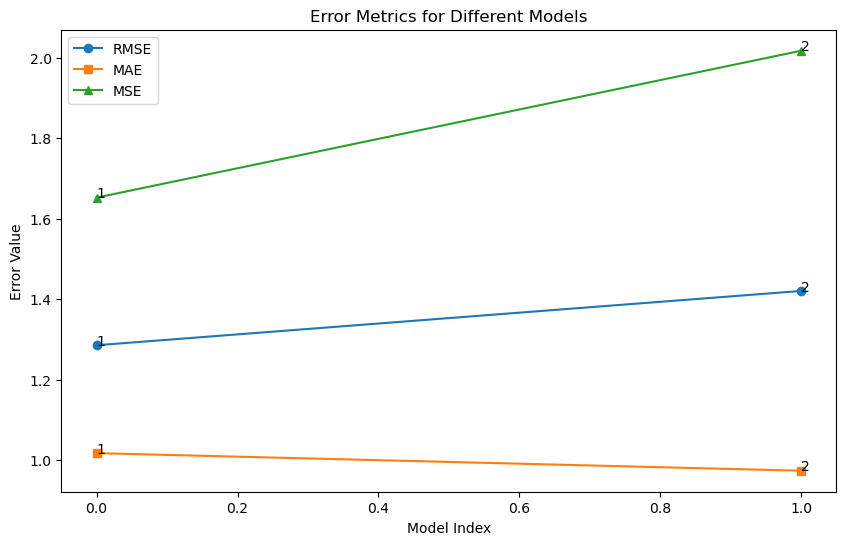

In [6]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

# Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

# Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

# Set title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

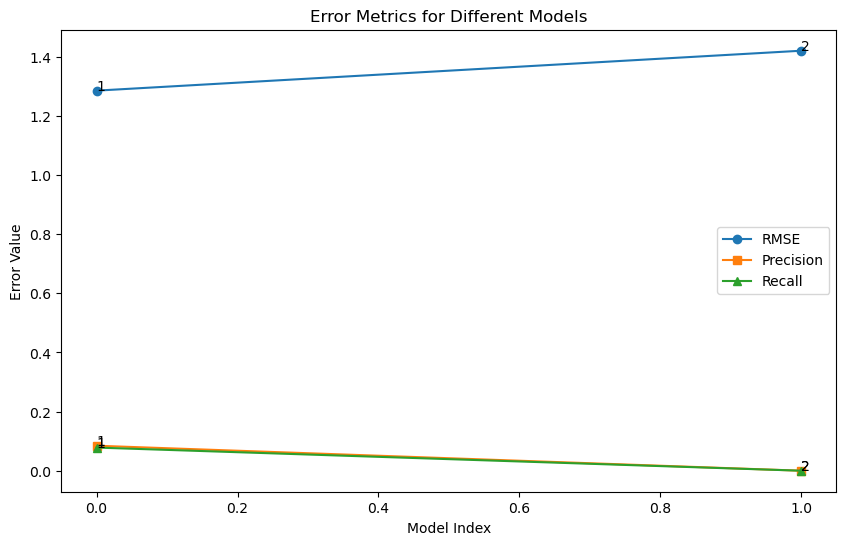

In [7]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

# Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

# Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

# Set title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

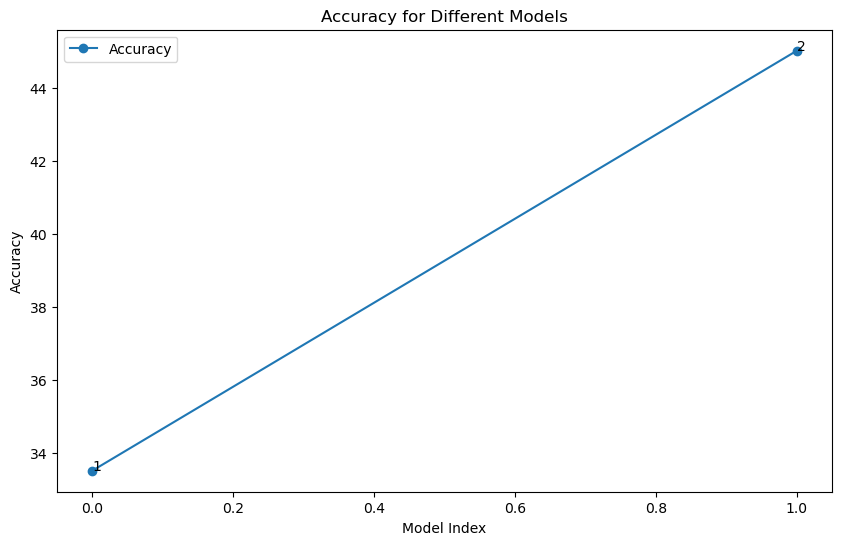

In [8]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

# Set title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.show()
